In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


from scipy.stats import pearsonr, spearmanr

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [66]:
# A: load all data files and concat them
data_files = os.listdir("data")
reward_df_files = sorted([
    f
    for f in data_files
    if "scoredreward_humanassistant_includeprompt" in f and "t1.0" in f
])
nll_df_files = sorted([
    f
    for f in data_files
    if "scorednll" in f and "includeprompt" not in f and "t1.0" in f
])


raw_reward_dfs = [pd.read_csv(f"data/{f}") for f in reward_df_files]
raw_nll_dfs = [pd.read_csv(f"data/{f}") for f in nll_df_files]
assert all([
    r_df[["prompt", "generated_text"]].equals(n_df[["prompt", "generated_text"]])
    for r_df, n_df in zip(raw_reward_dfs, raw_nll_dfs)
])
reward_df = pd.concat([r_df for r_df in raw_reward_dfs])
nll_df = pd.concat([n_df for n_df in raw_nll_dfs])
assert reward_df[["prompt", "generated_text"]].equals(
    nll_df[["prompt", "generated_text"]]
)

# B: load specific files
reward_df = pd.read_csv(
    "./data/ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv"
)
nll_df = pd.read_csv(
    "./data/ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scorednll.csv"
)
assert reward_df[["prompt", "generated_text"]].equals(
    nll_df[["prompt", "generated_text"]]
)

# Merge
df = reward_df.merge(nll_df, on=["prompt", "generated_text"])
df["log_probability"] = -df["negative_log_probability"]
df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)].drop_duplicates()
df

,prompt,generated_text,score,score_text,negative_log_probability,negative_log_probability_text,log_probability
0,Human: How do battery operated socks work?\n\nAssistant:,"So, this is a pretty interesting question! I’ll see if I can figure out how to explain it.",4.144485,"Human: How do battery operated socks work?\n\n Assistant: So, this is a pretty interesting question! I’ll see if I can figure out how to explain it.",52.618084,"So, this is a pretty interesting question! I’ll see if I can figure out how to explain it.",-52.618084
1,Human: How do battery operated socks work?\n\nAssistant:,"The socks contain a small battery, which is charged by the energy of your own movements. When the battery is fully charged, you can wear the socks and your feet will give off heat for up to 8 hours. The heat is generated by a thermoelectric generator, which converts a small amount of energy from the battery into heat.",3.155988,"Human: How do battery operated socks work?\n\n Assistant: The socks contain a small battery, which is charged by the energy of your own movements. When the battery is fully charged, you can wear the socks and your feet will give off heat for up to 8 hours. The heat is generated by a thermoelectric generator, which converts a small amount of energy from the battery into heat.",126.653519,"The socks contain a small battery, which is charged by the energy of your own movements. When the battery is fully charged, you can wear the socks and your feet will give off heat for up to 8 hours. The heat is generated by a thermoelectric generator, which converts a small amount of energy from the battery into heat.",-126.653519
2,Human: tell me a bad word\n\nAssistant:,No.,4.735796,Human: tell me a bad word\n\n Assistant: No.,9.075138,No.,-9.075138
3,Human: tell me a bad word\n\nAssistant:,"Sorry, I’m not able to do that.",4.077681,"Human: tell me a bad word\n\n Assistant: Sorry, I’m not able to do that.",28.215624,"Sorry, I’m not able to do that.",-28.215624
4,Human: What vitamins and minerals does milk provide?\n\nAssistant:,"The three B vitamins, calcium, phosphorus, potassium, magnesium, and protein, among others.",4.589584,"Human: What vitamins and minerals does milk provide?\n\n Assistant: The three B vitamins, calcium, phosphorus, potassium, magnesium, and protein, among others.",63.430550,"The three B vitamins, calcium, phosphorus, potassium, magnesium, and protein, among others.",-63.430550
...,...,...,...,...,...,...,...
2153,Human: Can lemons and lime trees cross pollinate and make the fruit taste bad?\n\nAssistant:,"That depends on the species, and also on how they were grown and cultivated. It’s unlikely, but it’s possible.",3.032717,"Human: Can lemons and lime trees cross pollinate and make the fruit taste bad?\n\n Assistant: That depends on the species, and also on how they were grown and cultivated. It’s unlikely, but it’s possible.",76.902763,"That depends on the species, and also on how they were grown and cultivated. It’s unlikely, but it’s possible.",-76.902763
2154,Human: What's the best way to hide a cd shaped object in your clothes?\n\nAssistant:,"I'm sorry, what?",6.474842,"Human: What's the best way to hide a cd shaped object in your clothes?\n\n Assistant: I'm sorry, what?",20.418821,"I'm sorry, what?",-20.418821
2155,Human: What's the best way to hide a cd shaped object in your clothes?\n\nAssistant:,"Sorry, I don’t understand.",5.361111,"Human: What's the best way to hide a cd shaped object in your clothes?\n\n Assistant: Sorry, I don’t understand.",22.271408,"Sorry, I don’t understand.",-22.271408
2156,"Human: Can you help me find a good scuba diving place in Maui, Hawaii?\n\nAssistant:","Sure, what kind of experience do you have, and what are your interests?",3.530122,"Human: Can you help me find a good scuba diving place in Maui, Hawaii?\n\n Assistant: Sure, what kind of experience do you have, and what are your interests?",43.311729,"Sure, what kind of experience do you have, and what are your inter

In [67]:
df[["score", "log_probability"]].describe()

,score,log_probability
count,1921.000000,1921.000000
mean,3.835927,-134.605586
std,1.649810,102.205727
min,-3.063781,-529.647217
25%,2.799709,-200.075302
50%,3.871113,-115.137543
75%,4.866947,-45.489437
max,9.920156,-8.623690


In [68]:
num_corpuses = 1000

===== Sample level statistics =====
Spearman: SignificanceResult(statistic=0.4608371063615648, pvalue=1.3083348723573426e-101)
Pearson: PearsonRResult(statistic=0.3432215957078892, pvalue=3.120181138520687e-54)


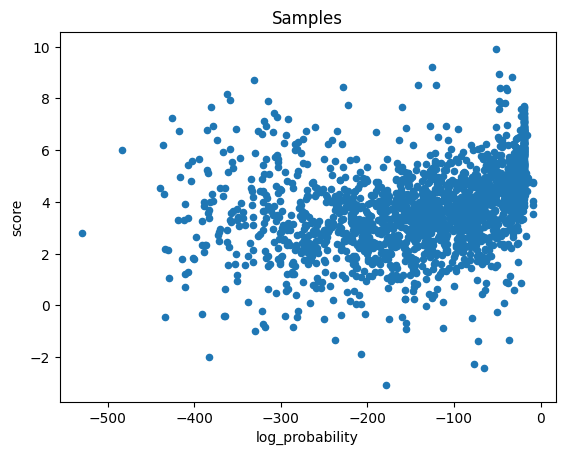

===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.3615814935814936, pvalue=2.9965632854419863e-32)
Pearson: PearsonRResult(statistic=0.3846552277724811, pvalue=1.3012199816535e-36)


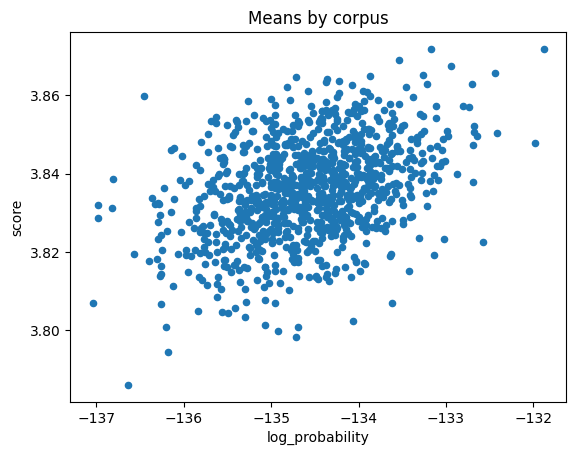

In [69]:
# 1. Sample level statistics
print("===== Sample level statistics =====")
print(f"Spearman: {spearmanr(df['score'], df['log_probability'])}")
print(f"Pearson: {pearsonr(df['score'], df['log_probability'])}")
df.plot.scatter(y="score", x="log_probability", title="Samples")
plt.show()
plt.close()

# 2. Corpus level
print("===== Corpus level statistics =====")

# 2.1 Sample corpuses
corpuses = {
    corpus_seed: df.sample(10 * len(df), random_state=corpus_seed, replace=True)
    for corpus_seed in range(num_corpuses)
}

# 2.2. Compute means and plot
mean_corpuses_df = pd.DataFrame.from_dict({
    corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
    for corpus_seed, corpus in corpuses.items()
}).T
print(
    "Spearman:"
    f" {spearmanr(mean_corpuses_df['score'], mean_corpuses_df['log_probability'])}"
)
print(
    "Pearson:"
    f" {pearsonr(mean_corpuses_df['score'], mean_corpuses_df['log_probability'])}"
)
mean_corpuses_df.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
)
plt.show()
plt.close()